In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,mean_squared_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# The dataset contains the following columns:

# Data Dictionary	
# column	definition
# ADV_ID	advertiser id
# AD_ID	ad id
# SKU	item identifier
# placement_slot	where ad ran
# impressions	number of times an ad ran (and was viewed)
# clicks	number of clicks it generated
# auction_cost	Auction cost is how much it cost to win the auction
# adjusted_cost	adjusted cost should be how much they actually paid given it's a second price auction
# hit_day_utc	day ad ran
# targeting_secondary	audience segment
# vertical	advertiser "best guess" vertical
# sub_vertical	advertiser "best guess" sub-vertical
# ntb_click_attributed_units_sold	new to brand (ntb) units sold that are attributable to clicks
# ntb_view_attributed_units_sold	new to brand (ntb) units sold that are attributable to views
# ntb_click_attributed_orders	new to brand (ntb) orders that are attributable to clicks
# ntb_view_attributed_orders	new to brand (ntb) orders that are attributable to views
# view_attributed_units_sold	total units sold attributable to views
# view_attributed_orders	total orders attributable to views


# Load CSV files into DataFrames
df = pd.read_csv('allAds.csv')

# print column names
print(df.columns)

# print number of unique counts in each column
# print(df.nunique())


# Find which columns have missing values
# print(df.isnull().sum())
# print(df.shape)

# clean the df by removing rows with missing values
df = df.dropna()
print(df.shape)

# Remove duplicates in the dataset
df = df.drop_duplicates()
print(df.shape)

# create a new column called 'dayOfWeek' that contains the day of the week that the ad was created from column 'hit_day_utc
df['dayOfWeek'] = pd.to_datetime(df['hit_day_utc']).dt.day_name()
print(df['dayOfWeek'].head())

# create a new column called 'month' that contains the month the ad was created from column 'hit_day_utc
df['month'] = pd.to_datetime(df['hit_day_utc']).dt.month


# print the categories in each column along with their counts for all columns
# for col in df.columns:
#     print(df[col].value_counts())
#     print('\n')

df['targeting_secondary'] = df['targeting_secondary'].str.replace('content-category=', '').str.replace('category=', '')

print(df.columns)
print(df.head())



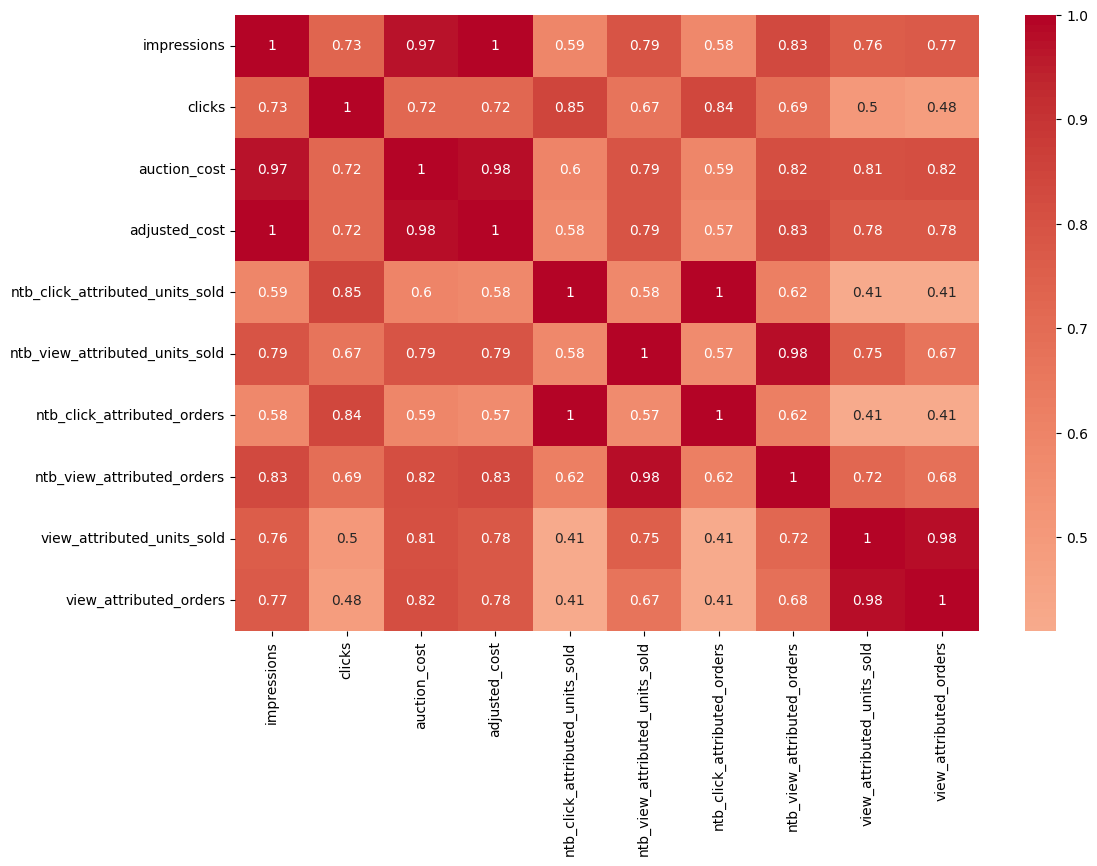

In [2]:
# CORRELATION MATRIX of continuos variables after grouping them by ad

continuos_variables = ['impressions', 'clicks', 'auction_cost', 'adjusted_cost', 'ntb_click_attributed_units_sold', 'ntb_view_attributed_units_sold', 'ntb_click_attributed_orders', 'ntb_view_attributed_orders', 'view_attributed_units_sold', 'view_attributed_orders']
df1 = df.groupby('AD_ID')[continuos_variables].sum()
# create a seaborn correlation heatmap with the continuos variables
corr = df1[continuos_variables].corr()
# round off the values to 2 decimal places
corr = corr.round(2)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.show()

In [ ]:
# DESCRIPTIVE STATISCTICS

# find descriptive statistics for the continuos variables grouping by ad
df1[continuos_variables].describe().round(1).rename(columns=lambda x: x.replace('_', ' ')).T


In [ ]:
# ANALYSIS USING PLOTS

bar_colors = ['#00528c'] * len(df['vertical'])

df1 = df.groupby(['AD_ID', 'vertical'])[continuos_variables].sum().reset_index()
# print(df1[df1['vertical'] == 'Financial Services'])
# print(df1.shape)
# Create the figure
plt.figure(figsize=(10,6))

df2 = df1.groupby('vertical')['impressions'].mean().reset_index()
df2 = df2.sort_values(by='impressions', ascending=False)

# print(df2.head(10))
# Create the barplot without vertical lines in the middle of the bars
sns.barplot(
    x='vertical', 
    y='impressions', 
    data=df2, 
    order=df2['vertical'], 
    palette=bar_colors, 
    errorbar=None
)

def millions_formatter(x, pos):
    return f'{x/1e6}M'

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))


# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add titles and labels
plt.title('Average Impressions by Vertical', fontsize=16, weight='bold',color='#20b2aa')
plt.xlabel('Vertical', fontsize=14,weight='bold',color='#20b2aa')
plt.ylabel('Impressions', fontsize=14,weight='bold',color='#20b2aa',labelpad=40)

sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()

In [ ]:

# Create the figure
plt.figure(figsize=(10,6))

df1 = df.groupby(['AD_ID', 'targeting_secondary'])[continuos_variables].sum().reset_index()
df1['targeting_secondary'] = df1['targeting_secondary'].str.replace('content-category=', '').str.replace('category=', '')

# Group by 'targeting_secondary' and sum 'clicks'
df2 = df1.groupby('targeting_secondary')['impressions'].sum().reset_index()

# Get the top 10 categories by 'clicks'
top10_categories = df2.nlargest(10, 'impressions')

# Set the color for the bars (length should match the number of bars)
bar_colors = ['#e1e733'] * len(top10_categories)

# Create the figure
plt.figure(figsize=(10, 6))

# Create the barplot without vertical lines in the middle of the bars
sns.barplot(x='targeting_secondary', y='impressions', data=top10_categories, 
            order=top10_categories['targeting_secondary'], palette=bar_colors, errorbar=None)


def millions_formatter(x, pos):
    return f'{int(x/1e6)}M'

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))


# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add titles and labels
plt.title('Total Impressions by Top 10 Targeting Secondary Categories', fontsize=16, weight='bold', color='#20b2aa')
plt.xlabel('Targeting Secondary', fontsize=14, weight='bold', color='#20b2aa')
plt.ylabel('Impressions', fontsize=14, weight='bold', color='#20b2aa', labelpad=20)

# Customize plot appearance
sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()

In [ ]:
bar_colors = ['#00528c'] * len(df['vertical'])


# Create the figure
plt.figure(figsize=(10,6))

df1 = df.groupby(['AD_ID', 'vertical'])[continuos_variables].sum().reset_index()

df2 = df.groupby('vertical')['clicks'].sum().reset_index()

print(df2.head(10))
# Create the barplot without vertical lines in the middle of the bars
sns.barplot(x='vertical', y='clicks', data=df2, order=df2.groupby('vertical')['clicks'].sum().sort_values(ascending=False).index, palette=bar_colors, errorbar=None)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add titles and labels
plt.title('Total clicks by Vertical', fontsize=16, weight='bold',color='#20b2aa')
plt.xlabel('Vertical', fontsize=14,weight='bold',color='#20b2aa')
plt.ylabel('Clicks', fontsize=14,weight='bold',color='#20b2aa',labelpad=40)

sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Filter and process the DataFrame
df1 = df.groupby(['AD_ID', 'targeting_secondary'])[continuos_variables].sum().reset_index()
df1['targeting_secondary'] = df1['targeting_secondary'].str.replace('content-category=', '').str.replace('category=', '')

# Group by 'targeting_secondary' and sum 'clicks'
df2 = df1.groupby('targeting_secondary')['clicks'].sum().reset_index()

# Get the top 10 categories by 'clicks'
top10_categories = df2.nlargest(10, 'clicks')

# Set the color for the bars (length should match the number of bars)
bar_colors = ['#9fffea'] * len(top10_categories)

# Create the figure
plt.figure(figsize=(10, 6))

# Create the horizontal barplot
sns.barplot(x='clicks', y='targeting_secondary', data=top10_categories, 
            order=top10_categories['targeting_secondary'], palette=bar_colors, errorbar=None)

# Customize the y-ticks and labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Add titles and labels
plt.title('Total Clicks by Top 10 Targeting Secondary Categories', fontsize=16, weight='bold', color='#0a3632')
plt.xlabel('Clicks', fontsize=14, weight='bold', color='#0a3632', labelpad=20)
plt.ylabel('Targeting Secondary', fontsize=14, weight='bold', color='#0a3632')

# Customize plot appearance
sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()


In [ ]:
from matplotlib.ticker import FuncFormatter

bar_colors = ['#8386bd'] * len(df['vertical'])

# df1 = df[(df['month'] == 3)]
df1 = df
# Create the figure
plt.figure(figsize=(10,6))

df2 = df1.groupby('dayOfWeek')['impressions'].sum().reset_index()

# Create the barplot without vertical lines in the middle of the bars
sns.barplot(x='dayOfWeek', y='impressions', data=df2, order=df2.groupby('dayOfWeek')['impressions'].sum().sort_values(ascending=False).index, palette=bar_colors, errorbar=None)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

def millions_formatter(x, pos):
    return f'{int(x/1e6)}M'

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Add titles and labels
plt.title('Total Impressions by day of week', fontsize=16, weight='bold',color='#37006c')
plt.xlabel('Day of Week', fontsize=14,weight='bold',color='#37006c',labelpad=20)
plt.ylabel('Impressions', fontsize=14,weight='bold',color='#37006c',labelpad=20)

sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter



df1 = df.groupby(['AD_ID', 'targeting_secondary','dayOfWeek'])['impressions'].sum().reset_index()
df1['targeting_secondary'] = df1['targeting_secondary'].str.replace('Probiotic', '').str.replace(' & Pods', '').str.replace('Single-Serve','')

# Sort the DataFrame by the summed impressions in descending order
df1 = df1.sort_values(by='impressions', ascending=False)

# Print the sorted DataFrame
print(df1[df1['impressions']>2500000].head(10))
# Create the figure
plt.figure(figsize=(10, 6))


# Create the violin plot
# sns.swarmplot(x='dayOfWeek', y='impressions', data=df2, palette='muted')
ax = sns.stripplot(data=df1, x="dayOfWeek", y="impressions", hue="dayOfWeek", legend=False, alpha =0.5)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

def millions_formatter(x, pos):
    return f'{x/1e6}M'

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Add titles and labels
plt.title('Total Impressions by Day of Week for each advertisemnt', fontsize=16, weight='bold', color='#37006c',pad =50)
plt.xlabel('Day of Week', fontsize=14, weight='bold', color='#37006c', labelpad=20)
plt.ylabel('Impressions', fontsize=14, weight='bold', color='#37006c', labelpad=20)


# Hide the grid lines
plt.grid(False)

threshold = 2650000
for i in range(len(df1)):
    if df1['impressions'][i] > threshold:
        # Find the x-coordinate by looking up the category position
        x = df1['dayOfWeek'].cat.categories.get_loc(df1['dayOfWeek'][i]) if hasattr(df1['dayOfWeek'], 'cat') else list(df1['dayOfWeek'].unique()).index(df1['dayOfWeek'][i])
        y = df1['impressions'][i]
        y_value = df1['targeting_secondary'][i]
        ax.text(x, y, f"{y_value}", ha='left', va='bottom', fontsize=10)

# for spine in ax.spines.values():
#     spine.set_edgecolor('#37006c')
#     spine.set_linewidth(1.5)

sns.despine(left=True, bottom=True)

# print('coordinates',coordinates)
# Display the plot
plt.show()


In [ ]:
from matplotlib.ticker import FuncFormatter

bar_colors = ['#8386bd'] * len(df['vertical'])

# df1 = df[(df['month'] == 3)]
df1 = df
# Create the figure
plt.figure(figsize=(10,6))

df2 = df1.groupby('placement_slot')['impressions'].sum().reset_index()

# Create the barplot without vertical lines in the middle of the bars
sns.barplot(x='placement_slot', y='impressions', data=df2, order=df1.groupby('placement_slot')['impressions'].sum().sort_values(ascending=False).index, palette=bar_colors, errorbar=None)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

def millions_formatter(x, pos):
    return f'{x/1e8}B'

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Add titles and labels
plt.title('Total Impressions by placement_slot', fontsize=16, weight='bold',color='#37006c')
plt.xlabel('Placement slot', fontsize=14,weight='bold',color='#37006c',labelpad=20)
plt.ylabel('Impressions', fontsize=14,weight='bold',color='#37006c',labelpad=20)

sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

# df1 = df[df['month']==3]

df1 = df.groupby(['AD_ID', 'placement_slot'])['impressions'].sum().reset_index()

# Sort the DataFrame by the summed impressions in descending order
df1 = df1.sort_values(by='impressions', ascending=False)

# Print the sorted DataFrame
# print(df1[df1['impressions']>2500000].head(10))
# Create the figure
plt.figure(figsize=(10, 6))


# Create the violin plot
# sns.swarmplot(x='dayOfWeek', y='impressions', data=df2, palette='muted')
ax = sns.stripplot(data=df1, x="placement_slot", y="impressions", hue="placement_slot", legend=False, alpha =0.5)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

def millions_formatter(x, pos):
    return f'{10*x/1e7}M'

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Add titles and labels
plt.title('Total Impressions by placement slot for each advertisemnt', fontsize=16, weight='bold', color='#37006c')
plt.xlabel('Placement Slot', fontsize=14, weight='bold', color='#37006c', labelpad=20)
plt.ylabel('Impressions', fontsize=14, weight='bold', color='#37006c', labelpad=20)

sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# threshold = 2650000
# for i in range(len(df1)):
#     if df1['impressions'][i] > threshold:
#         # Find the x-coordinate by looking up the category position
#         x = df1['dayOfWeek'].cat.categories.get_loc(df1['dayOfWeek'][i]) if hasattr(df1['dayOfWeek'], 'cat') else list(df1['dayOfWeek'].unique()).index(df1['dayOfWeek'][i])
#         y = df1['impressions'][i]
#         y_value = df1['targeting_secondary'][i]
#         ax.text(x, y, f"{y_value}", ha='left', va='bottom', fontsize=10)

# print('coordinates',coordinates)
# Display the plot
plt.show()


In [ ]:
bar_colors = ['#ff4d9b'] * len(df['vertical'])

# df1 = df[(df['month'] == 3)]


# Create the figure
plt.figure(figsize=(10,6))

df2 = df.groupby('dayOfWeek')['clicks'].sum().reset_index()

# Create the barplot without vertical lines in the middle of the bars
sns.barplot(x='dayOfWeek', y='clicks', data=df2, order=df2.groupby('dayOfWeek')['clicks'].sum().sort_values(ascending=False).index, palette=bar_colors, errorbar=None)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add titles and labels
plt.title('Total clicks by the day of week', fontsize=16, weight='bold',color='#37006c')
plt.xlabel('Day of Week', fontsize=14,weight='bold',color='#37006c')
plt.ylabel('Clicks', fontsize=14,weight='bold',color='#37006c',labelpad=40)

sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

# df1 = df[df['month']==3]

df1 = df.groupby(['AD_ID', 'dayOfWeek','targeting_secondary'])['clicks'].sum().reset_index()

df['targeting_secondary'] = df['targeting_secondary'].str.replace('Probiotic', '').str.replace(' & Pods', '').str.replace('Single-Serve','')

# Sort the DataFrame by the summed impressions in descending order
df1 = df1.sort_values(by='clicks', ascending=False)

# Print the sorted DataFrame
print(df1[df1['clicks']>1000].head(10))
# Create the figure
plt.figure(figsize=(10, 6))


# Create the violin plot
# sns.swarmplot(x='dayOfWeek', y='impressions', data=df2, palette='muted')
ax = sns.stripplot(data=df1, x="dayOfWeek", y="clicks", hue="dayOfWeek", legend=False, alpha =0.5)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# def millions_formatter(x, pos):
#     return f'{10*x/1e7}M'

# # Apply the formatter to the y-axis
# plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Add titles and labels
plt.title('Total clicks by day of week for each advertisemnt', fontsize=16, weight='bold', color='#37006c')
plt.xlabel('Day of week', fontsize=14, weight='bold', color='#37006c', labelpad=20)
plt.ylabel('Clicks', fontsize=14, weight='bold', color='#37006c', labelpad=20)


# Set the color and linewidth of the spines
for spine in ax.spines.values():
    spine.set_edgecolor('#37006c')
    spine.set_linewidth(1.5)

sns.despine(left=False, bottom=False)

# Hide the grid lines
plt.grid(False)

threshold = 1252
for i in range(len(df1)):
    if df1['clicks'][i] > threshold:
        # Find the x-coordinate by looking up the category position
        x = df1['dayOfWeek'].cat.categories.get_loc(df1['dayOfWeek'][i]) if hasattr(df1['dayOfWeek'], 'cat') else list(df1['dayOfWeek'].unique()).index(df1['dayOfWeek'][i])
        y = df1['clicks'][i]
        y_value = df1['targeting_secondary'][i]
        ax.text(x, y, f"{y_value}", ha='left', va='center', fontsize=9)

# print('coordinates',coordinates)
# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is already defined and processed as shown in your example
df1 = df.groupby(['AD_ID', 'vertical', 'targeting_secondary'])['clicks'].sum().reset_index()

df['targeting_secondary'] = df['targeting_secondary'].str.replace('Probiotic', '').str.replace(' & Pods', '').str.replace('Single-Serve', '').str.replace('Digestive', '')

# Sort the DataFrame by the summed clicks in descending order
df1 = df1.sort_values(by='clicks', ascending=False)

# Print the sorted DataFrame
print(df1[df1['clicks'] > 1000].head(10))

# Create the figure
plt.figure(figsize=(10, 6))

# Create the strip plot
ax = sns.stripplot(data=df1, x="vertical", y="clicks", hue="vertical", legend=False, alpha=0.5)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add titles and labels
plt.title('Total clicks by vertical for each advertisement', fontsize=16, weight='bold', color='#37006c', pad=50)
plt.xlabel('Vertical', fontsize=14, weight='bold', color='#37006c', labelpad=20)
plt.ylabel('Clicks', fontsize=14, weight='bold', color='#37006c', labelpad=20)

# Customize the spines to create a box around the plot
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Set the color and linewidth of the spines
for spine in ax.spines.values():
    spine.set_edgecolor('#37006c')
    spine.set_linewidth(1.5)

sns.despine(left=False, bottom=False)

# Hide the grid lines
plt.grid(False)

threshold = 1970
for i in range(len(df1)):
    if df1['clicks'][i] > threshold:
        # Find the x-coordinate by looking up the category position
        x = (df1['vertical'].cat.categories.get_loc(df1['vertical'][i])+0.01) if hasattr(df1['vertical'], 'cat') else list(df1['vertical'].unique()).index(df1['vertical'][i])+0.01
        y = df1['clicks'][i]
        y_value = df1['targeting_secondary'][i]
        ax.text(x, y, f"{y_value}", ha='left', va='center', fontsize=9)

# Display the plot
plt.show()


In [ ]:
bar_colors = ['#5dd4a2'] * len(df['vertical'])

df2 = df.groupby(['AD_ID', 'vertical'])[continuos_variables].sum().reset_index()

# Create the figure
plt.figure(figsize=(10,6))

df2 = df2.groupby('vertical')['auction_cost'].sum().reset_index()

print(df2.head(10))
# Create the barplot without vertical lines in the middle of the bars
sns.barplot(x='vertical', y='auction_cost', data=df2, order=df2.groupby('vertical')['auction_cost'].sum().sort_values(ascending=False).index, palette=bar_colors, errorbar=None)

def millions_formatter(x, pos):
    return f'{(x/1e6)}M'

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))


# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add titles and labels
plt.title('Total Auction cost by Vertical', fontsize=16, weight='bold',color='#1a7277')
plt.xlabel('Vertical', fontsize=14,weight='bold',color='#1a7277')
plt.ylabel('Auction Cost', fontsize=14,weight='bold',color='#1a7277',labelpad=40)

sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()

In [ ]:
bar_colors = ['#5dd4a2'] * len(df['vertical'])

df2 = df.groupby(['AD_ID', 'dayOfWeek'])[continuos_variables].sum().reset_index()

# Create the figure
plt.figure(figsize=(10,6))

df2 = df2.groupby('dayOfWeek')['auction_cost'].sum().reset_index()

print(df2.head(10))
# Create the barplot without vertical lines in the middle of the bars
sns.barplot(x='dayOfWeek', y='auction_cost', data=df2, order=df2.groupby('dayOfWeek')['auction_cost'].sum().sort_values(ascending=False).index, palette=bar_colors, errorbar=None)

# Customize the x-ticks and labels
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add titles and labels
plt.title('Total Auction cost by Day of Week', fontsize=16, weight='bold',color='#1a7277')
plt.xlabel('Day of Week', fontsize=14,weight='bold',color='#1a7277')
plt.ylabel('Auction Cost', fontsize=14,weight='bold',color='#1a7277',labelpad=40)

sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()

In [ ]:
df1 = df[(df['month'] == 4)]

sns.set_style('white', {'legend.frameon':True})

cmap = sns.cubehelix_palette(n_colors=len(df1['placement_slot'].unique()))

# Create the scatter plot
g = sns.relplot(
    data=df1,
    x="vertical", 
    y="impressions",
    size="view_attributed_orders",
    palette=cmap, 
    sizes=(10, 200),
    alpha=0.6 
)
g.fig.set_size_inches(10,6)

# Add titles and labels
plt.title('Impressions by Vertical for the month of April', fontsize=16, weight='bold', color='#154360', loc='center', pad=20)
plt.xlabel('Vertical', fontsize=14,weight='bold',color='#154360')
plt.ylabel('Impressions', fontsize=14,weight='bold',color='#154360',labelpad=40)


# Set the title of the legend
leg = g._legend
leg.set_title("View Attributed Orders")

# Adjust the font properties of the legend title
leg.get_title().set_fontsize(12)
leg.get_title().set_weight('bold')
leg.get_title().set_color('#154360')


g.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.grid(False)

plt.show()

In [ ]:
    
df1 = df[(df['month'] == 4)]

category_order = ['offsite_mobileweb', 'offsite_mobileapp', 'offsite_desktop']

# Create a custom color palette with the specified order
cmap = sns.color_palette("Oranges", n_colors=len(category_order))

# Create the scatter plot
g = sns.relplot(
    data=df1,
    x="vertical", 
    y="impressions",
    hue="placement_slot",
    palette=cmap, 
    hue_order=category_order,
    s=70,
    alpha=0.6 
)
# g.legend(prop={'size': 20})
g.fig.set_size_inches(10,6)

# Add titles and labels
plt.title('Impressions by Vertical (April)', fontsize=16, weight='bold', color='#154360', loc='center', pad=20)
plt.xlabel('Vertical', fontsize=14,weight='bold',color='#154360')
plt.ylabel('Impressions', fontsize=14,weight='bold',color='#154360',labelpad=40)

# Set the title of the legend
leg = g._legend
leg.set_title("Where did the ad run?")

# Adjust the font properties of the legend title
leg.get_title().set_fontsize(12)
leg.get_title().set_weight('bold')
leg.get_title().set_color('#154360')


g.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


In [ ]:
df1 = df[(df['month'] == 4) & (df['vertical'] == 'Consumer Packaged Goods')]

sns.set_style('white', {'legend.frameon':True})

cmap = sns.cubehelix_palette(n_colors=len(df1['placement_slot'].unique()))

# Create the scatter plot
g = sns.relplot(
    data=df1,
    x="sub_vertical", 
    y="impressions",
    size="view_attributed_orders",
    palette=cmap, 
    sizes=(10, 200),
    alpha=0.5
)
g.fig.set_size_inches(10,6)

# Add titles and labels
plt.title('Impressions by Sub Vertical for Consumer Packaged Goods(April)', fontsize=16, weight='bold', color='#154360', loc='center', pad=20)
plt.xlabel('Sub Vertical', fontsize=14,weight='bold',color='#154360')
plt.ylabel('Impressions', fontsize=14,weight='bold',color='#154360',labelpad=40)


# Set the title of the legend
leg = g._legend
leg.set_title("View Attributed Orders")

# Adjust the font properties of the legend title
leg.get_title().set_fontsize(12)
leg.get_title().set_weight('bold')
leg.get_title().set_color('#154360')


g.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.grid(False)

plt.show()

In [ ]:

df1 = df

df1 = df[(df['month'] == 4) & (df['sub_vertical'] == 'Grocery - Food') & (df['impressions'] > 3500)]
df1['targeting_secondary'] = df1['targeting_secondary'].str.replace('content-category=', '').str.replace('category=', '')

sns.set_style('white', {'legend.frameon': True})

# Define the color and transparency
purple_transparent = (148/255, 0/255, 211/255, 0.5)  # RGBA format where A is alpha for transparency

# Create the scatter plot
g = sns.relplot(
    data=df1,
    x="targeting_secondary", 
    y="impressions",
    size="view_attributed_orders",
    sizes=(10, 200),
    color=purple_transparent
)
g.fig.set_size_inches(10, 6)

# Add titles and labels
plt.title('Impressions by Targeting Secondary for Grocery Foods', fontsize=16, weight='bold', color='#154360', loc='center', pad=20)
plt.xlabel('Targeting Secondary', fontsize=14, weight='bold', color='#154360')
plt.ylabel('Impressions', fontsize=14, weight='bold', color='#154360', labelpad=40)

# Set the title of the legend
leg = g._legend
leg.set_title("View Attributed Orders")

# Adjust the font properties of the legend title
leg.get_title().set_fontsize(12)
leg.get_title().set_weight('bold')
leg.get_title().set_color('#154360')

g.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.grid(False)

plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# print(df1['dayOfWeek'].cat.codes)
df1 = df[(df['month'] == 3)]
df1['dayOfWeek'] = df1['dayOfWeek'].astype('category')


day_to_number = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

day_colors = {
    'Monday': 'blue',
    'Tuesday': 'orange',
    'Wednesday': 'green',
    'Thursday': 'red',
    'Friday': 'yellow',
    'Saturday': 'brown',
    'Sunday': 'pink'
}

dayno_colors = {
    0: 'blue',
    1: 'orange',
    2: 'green',
    3: 'red',
    4: 'yellow',
    5: 'brown',
    6: 'pink'
}

# Create a new column 'dayOfWeek_num' with assigned numbers based on the dictionary
df1['dayOfWeek_num'] = df1['dayOfWeek'].map(day_to_number)

ax.scatter(
    x=df1['clicks'], 
    y=df1['view_attributed_orders'], 
    s=df1['impressions']/20, 
    c=df1['dayOfWeek_num'].map(dayno_colors),  # Use the explicitly assigned numbers
    cmap="Accent", 
    alpha=0.6, 
    edgecolors="white", 
    linewidth=2
)
 
# Create a legend with custom colors for each day of the week
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=day) for day, color in day_colors.items()]

impression_handle = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=15, label='impressions')]

# Add titles and labels
ax.set_xlabel('Clicks')
ax.set_ylabel('View Attributed Orders')
ax.set_title('View Atributed Orders vs Clicks')

legend1 = ax.legend(handles=legend_handles, title='Day Of Week', loc='upper right')
ax.add_artist(legend1)
legend2 = ax.legend(handles=impression_handle, title='Size of the bubble', loc='center right')
ax.add_artist(legend2)

# all_handles = legend_handles + impression_handle

# # Show legend with combined handles and labels
# plt.legend(handles=all_handles, title='Day Of Week')
# plt.legend.append(handles=impression_handle, title='Size of the bubble')
plt.grid(False)
plt.show()

In [ ]:
df1 = df
# Define custom palette with transparency
palette = {
    'Monday': (0, 0, 1, 0.7),       # Blue with 50% transparency
    'Tuesday': (1, 0.5, 0, 0.7),    # Orange with 50% transparency
    'Wednesday': (0.6, 0.4, 0.2, 0.7),    # Green with 50% transparency
    'Thursday': (1, 0, 0, 0.7),     # Red with 50% transparency
    'Friday': (0.5, 0, 0.5, 0.7),   # Purple with 50% transparency
    'Saturday': (0, 1, 0, 0.7) , # Brown with 50% transparency
    'Sunday': (1, 0.75, 0.8, 0.7)   # Pink with 50% transparency
}

# Set the style
sns.set_style('whitegrid')

# Create the lmplot with custom markers and palette
sns.lmplot(x='auction_cost', y='impressions', data=df1,  
           hue='dayOfWeek', markers=['o', 'v', '^', 'p', 'd', 's', '*'], 
           palette=palette, legend=False)

# Add titles and labels
plt.title('Relation between auction cost and number of impressions for each ad', fontsize=16, weight='bold', color='#154360', loc='center', pad=20)
plt.xlabel('Auction Cost', fontsize=14, weight='bold', color='#154360')
plt.ylabel('Impressions', fontsize=14, weight='bold', color='#154360', labelpad=40)


# Customize the plot
plt.grid(False)
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and continuos_variables includes 'impressions'

df['hit_day_utc'] = pd.to_datetime(df['hit_day_utc'])

# Define the specific datetime including the time
specific_datetime = pd.to_datetime('4/30/2024 12:00:00 AM')

# Select rows where 'hit_day_utc' matches the specific datetime
df1 = df[df['hit_day_utc'] == specific_datetime]

df1 = df1.groupby(['AD_ID'])[continuos_variables].mean().reset_index()

def create_dummies(auctionCost):
    if auctionCost < 30:
        return '<$30'
    elif 30 <= auctionCost < 50:
        return '$(30-50)'
    elif 50 <= auctionCost < 100:
        return '$(50-100)'
    elif 100 <= auctionCost < 200:
        return '$(100-200)'
    else:
        return '>$200'

# Apply the function to create dummy variables
df1['AuctionCost'] = df1['auction_cost'].apply(create_dummies)

# Convert dummy variables to one-hot encoding
dummy_variables = pd.get_dummies(df1['AuctionCost'])

# Concatenate dummy variables with the original DataFrame
df1 = pd.concat([df1, dummy_variables], axis=1)

# Sum the dummy variables to get the count of each category
category_counts = dummy_variables.sum().reset_index()
category_counts.columns = ['AuctionCost', 'Count']

# Calculate the sum of 'impressions' for each AuctionCost category
impressions_sum = df1.groupby('AuctionCost')['impressions'].sum().reset_index()

# Merge the counts and impressions sum data
category_counts = category_counts.merge(impressions_sum, on='AuctionCost')
print(category_counts)

# Set the color for the bars
bar_colors = ['#d0efff'] * len(category_counts)

# Create the figure
plt.figure(figsize=(10, 6))

# Create the horizontal barplot
ax = sns.barplot(x='Count', y='AuctionCost', data=category_counts, 
            order=category_counts.sort_values(by='Count', ascending=False)['AuctionCost'], 
            palette=bar_colors, errorbar=None)

# Customize the y-ticks and labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Add titles and labels
plt.title('Average Bidding Cost by Ads for a Single Day (April 30)', fontsize=16, weight='bold', color='#021076')
plt.xlabel('Count', fontsize=14, weight='bold', color='#021076', labelpad=20)
plt.ylabel('Auction Cost Category', fontsize=14, weight='bold', color='#021076')

# Add labels for the sum of 'impressions' on the right of each bar
# for i in range(len(category_counts)):
#     ax.annotate(f"{category_counts['impressions'][i]:,.0f} impressions", 
#                 xy=(category_counts['Count'][i], i), 
#                 xytext=(5,0),  # 5 points to the right
#                 textcoords='offset points',
#                 color='black', ha="left", va="center", fontsize=12)

# Customize plot appearance
sns.despine(left=True, bottom=True)

# Hide the grid lines
plt.grid(False)

# Display the plot
plt.show()


In [ ]:
# MODELING

# merge the two file on the columns ADV_ID,AD_ID, SKU, placement_slot, hit_day_utc, targeting_secondary and export it to a csv File called Adslatest.csv
df11 = pd.read_csv('allAds.csv')
df12 = pd.read_csv('someAds.csv')
df = pd.concat([df11, df12], ignore_index=True)

# Export to a new CSV file
# df.to_csv('Ads2.csv', index=False)
print(df.shape)

df = df.dropna()
print(df.shape)

df = df.drop_duplicates()
print(df.shape)

# create a new column called 'dayOfWeek' that contains the day of the week that the ad was created from column 'hit_day_utc
df['hit_day_utc'] = pd.to_datetime(df['hit_day_utc'], errors='coerce')
df['dayOfWeek'] = df['hit_day_utc'].dt.day_name()


dummy_variables = pd.get_dummies(df['vertical'])
dummy_variables = dummy_variables.astype(int) 
df = pd.concat([df, dummy_variables], axis=1)

dummy_variables = pd.get_dummies(df['dayOfWeek'])
dummy_variables = dummy_variables.astype(int) 
df = pd.concat([df, dummy_variables], axis=1)

df['weekend'] = np.where(df['dayOfWeek'].isin(['Sunday', 'Saturday']), 1, 0)
df['mobile'] = np.where(df['placement_slot'].isin(['offsite_mobileapp', 'offsite_mobileweb']), 1, 0)
df['desktop'] = np.where(df['placement_slot'] == 'offsite_desktop', 1, 0)
continuos_variables = ['impressions', 'clicks', 'auction_cost', 'adjusted_cost', 'ntb_click_attributed_units_sold', 'ntb_view_attributed_units_sold', 'ntb_click_attributed_orders', 'ntb_view_attributed_orders', 'view_attributed_units_sold', 'view_attributed_orders']


# print(df.head(10))
print(df.columns)

print(df[continuos_variables].describe())

In [ ]:

# LINEAR REGRESSION
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve, auc

df['intercept'] = 1

df_category = df
# df_category = df.loc[(df['vertical'] == 'Automotive')]

print(df_category.shape)
# for col in df_category.columns:
#     print(df_category[col].value_counts())
#     print('\n')

# model an optimal audience targeting strategy that maximizes viewable impressions for advertisers.
X = df_category[['intercept','desktop', 'adjusted_cost', 'Sunday','Saturday','Monday',
     'Friday','Tuesday','Wednesday','Automotive',
       'Consumer Packaged Goods', 'Financial Services',
       'Publishing', 'Hardlines', 'Telco', 'view_attributed_orders']]
y = df_category['impressions']

# Reference Variables
# 'Friday', 'Monday', 'Saturday',
#        'Sunday', 'Thursday', 'Tuesday', 'Wednesday'
# 'adjustedCost<500','adjustedCost<2000','adjustedCost>2000'
# Standardize the features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

print(X.head(10))

print(y.head(10))      
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)


print(X.shape)
print(y.shape)

# Fit linear regression model
linear_model = sm.OLS(y_train, X_train).fit()



# # Print summary of the model
print(linear_model.summary())

# Prediction
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MSE:", train_mse)
print("Training R^2:", train_r2)

print("Testing MSE:", test_mse)
print("Testing R^2:", test_r2)

threshold = y_train.median()

# Convert continuous predictions to binary classes
y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

# Confusion matrix for training set
train_cm = confusion_matrix(y_train_binary, y_train_pred_binary)
# Confusion matrix for testing set
test_cm = confusion_matrix(y_test_binary, y_test_pred_binary)

# Precision, recall, and accuracy for training set
train_precision = precision_score(y_train_binary, y_train_pred_binary)
train_recall = recall_score(y_train_binary, y_train_pred_binary)
train_accuracy = accuracy_score(y_train_binary, y_train_pred_binary)

# Precision, recall, and accuracy for testing set
test_precision = precision_score(y_test_binary, y_test_pred_binary)
test_recall = recall_score(y_test_binary, y_test_pred_binary)
test_accuracy = accuracy_score(y_test_binary, y_test_pred_binary)

# Calculate Precision-Recall AUC for training set
precision_train, recall_train, _ = precision_recall_curve(y_train_binary, y_train_pred)
pr_auc_train = auc(recall_train, precision_train)

# Calculate Precision-Recall AUC for testing set
precision_test, recall_test, _ = precision_recall_curve(y_test_binary, y_test_pred)
pr_auc_test = auc(recall_test, precision_test)

# Print the results
print("Training set confusion matrix:")
print(train_cm)
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision-Recall AUC: {pr_auc_train}")

print("\nTesting set confusion matrix:")
print(test_cm)
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision-Recall AUC: {pr_auc_test}")


# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))

# Training set
plt.plot(recall_train, precision_train, label=f'Train AUC = {pr_auc_train:.3f}', color='blue')
# Testing set
plt.plot(recall_test, precision_test, label=f'Test AUC = {pr_auc_test:.3f}', color='green')

# Plot settings
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(False)
plt.show()

In [ ]:
# RANDOM FOREST MODEL

rf_model = RandomForestRegressor()
# Fit the model
rf_model.fit(X_train, y_train)
# Predict on training and testing data
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print feature importances
feature_importances = rf_model.feature_importances_

# Summary of the model
print("Random Forest Regressor Summary:")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")
print("Feature Importances:")
for feature_name, importance in zip(X.columns, feature_importances):
    print(f"{feature_name}: {importance}")

#print the model's parameters
print("\nModel Parameters:")
print(rf_model.get_params())

threshold = y_train.median()

# Convert continuous predictions to binary classes
y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

# Confusion matrix for training set
train_cm = confusion_matrix(y_train_binary, y_train_pred_binary)
# Confusion matrix for testing set
test_cm = confusion_matrix(y_test_binary, y_test_pred_binary)

# Precision, recall, and accuracy for training set
train_precision = precision_score(y_train_binary, y_train_pred_binary)
train_recall = recall_score(y_train_binary, y_train_pred_binary)
train_accuracy = accuracy_score(y_train_binary, y_train_pred_binary)

# Precision, recall, and accuracy for testing set
test_precision = precision_score(y_test_binary, y_test_pred_binary)
test_recall = recall_score(y_test_binary, y_test_pred_binary)
test_accuracy = accuracy_score(y_test_binary, y_test_pred_binary)

# Calculate Precision-Recall AUC for training set
precision_train, recall_train, _ = precision_recall_curve(y_train_binary, y_train_pred)
pr_auc_train = auc(recall_train, precision_train)

# Calculate Precision-Recall AUC for testing set
precision_test, recall_test, _ = precision_recall_curve(y_test_binary, y_test_pred)
pr_auc_test = auc(recall_test, precision_test)

# Print the results
print("Training set confusion matrix:")
print(train_cm)
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision-Recall AUC: {pr_auc_train}")

print("\nTesting set confusion matrix:")
print(test_cm)
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision-Recall AUC: {pr_auc_test}")


# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))

# Training set
plt.plot(recall_train, precision_train, label=f'Train AUC = {pr_auc_train:.3f}', color='blue')
# Testing set
plt.plot(recall_test, precision_test, label=f'Test AUC = {pr_auc_test:.3f}', color='green')

# Plot settings
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(False)
plt.show()

In [ ]:
# # BAGGING - DECISION TREE

# from sklearn.ensemble import BaggingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve, auc
# import matplotlib.pyplot as plt

# # Bagging Regressor with DecisionTreeRegressor as the base estimator
# bagging_model = BaggingRegressor(
#     base_estimator=DecisionTreeRegressor(),
#     n_estimators=100,  # number of base estimators
#     random_state=42,
#     n_jobs=-1  # use all available cores
# )

# # Fit the model
# bagging_model.fit(X_train, y_train)

# # Predict on training and testing data
# y_train_pred = bagging_model.predict(X_train)
# y_test_pred = bagging_model.predict(X_test)

# # Calculate performance metrics
# train_mse = mean_squared_error(y_train, y_train_pred)
# test_mse = mean_squared_error(y_test, y_test_pred)
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# # Summary of the model
# print("Bagging Regressor Summary:")
# print(f"Train MSE: {train_mse}")
# print(f"Test MSE: {test_mse}")
# print(f"Train R^2: {train_r2}")
# print(f"Test R^2: {test_r2}")

# # Print the model's parameters
# print("\nModel Parameters:")
# print(bagging_model.get_params())

# threshold = y_train.median()

# # Convert continuous predictions to binary classes
# y_train_binary = (y_train > threshold).astype(int)
# y_test_binary = (y_test > threshold).astype(int)
# y_train_pred_binary = (y_train_pred > threshold).astype(int)
# y_test_pred_binary = (y_test_pred > threshold).astype(int)

# # Confusion matrix for training set
# train_cm = confusion_matrix(y_train_binary, y_train_pred_binary)
# # Confusion matrix for testing set
# test_cm = confusion_matrix(y_test_binary, y_test_pred_binary)

# # Precision, recall, and accuracy for training set
# train_precision = precision_score(y_train_binary, y_train_pred_binary)
# train_recall = recall_score(y_train_binary, y_train_pred_binary)
# train_accuracy = accuracy_score(y_train_binary, y_train_pred_binary)

# # Precision, recall, and accuracy for testing set
# test_precision = precision_score(y_test_binary, y_test_pred_binary)
# test_recall = recall_score(y_test_binary, y_test_pred_binary)
# test_accuracy = accuracy_score(y_test_binary, y_test_pred_binary)

# # Calculate Precision-Recall AUC for training set
# precision_train, recall_train, _ = precision_recall_curve(y_train_binary, y_train_pred)
# pr_auc_train = auc(recall_train, precision_train)

# # Calculate Precision-Recall AUC for testing set
# precision_test, recall_test, _ = precision_recall_curve(y_test_binary, y_test_pred)
# pr_auc_test = auc(recall_test, precision_test)

# # Print the results
# print("Training set confusion matrix:")
# print(train_cm)
# print(f"Train Precision: {train_precision}")
# print(f"Train Recall: {train_recall}")
# print(f"Train Accuracy: {train_accuracy}")
# print(f"Train Precision-Recall AUC: {pr_auc_train}")

# print("\nTesting set confusion matrix:")
# print(test_cm)
# print(f"Test Precision: {test_precision}")
# print(f"Test Recall: {test_recall}")
# print(f"Test Accuracy: {test_accuracy}")
# print(f"Test Precision-Recall AUC: {pr_auc_test}")

# # Plot Precision-Recall curve
# plt.figure(figsize=(10, 6))

# # Training set
# plt.plot(recall_train, precision_train, label=f'Train AUC = {pr_auc_train:.3f}', color='blue')
# # Testing set
# plt.plot(recall_test, precision_test, label=f'Test AUC = {pr_auc_test:.3f}', color='green')

# # Plot settings
# plt.title('Precision-Recall Curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.legend(loc='lower left')
# plt.grid(False)
# plt.show()

In [ ]:
# STACKING
# from sklearn.ensemble import StackingRegressor
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve, auc
# import matplotlib.pyplot as plt

# # Stacking: When you want to optimize performance using diverse models and can invest in a more complex setup.
    
# # Base models
# base_models = [
#     ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
#     ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
#     ('et', ExtraTreesRegressor(n_estimators=100, random_state=42))
# ]

# # Stacking Regressor with Linear Regression as final estimator
# stacking_model = StackingRegressor(
#     estimators=base_models,
#     final_estimator=LinearRegression()
# )

# # Fit the model
# stacking_model.fit(X_train, y_train)

# # Predict on training and testing data
# y_train_pred = stacking_model.predict(X_train)
# y_test_pred = stacking_model.predict(X_test)

# # Calculate performance metrics
# train_mse = mean_squared_error(y_train, y_train_pred)
# test_mse = mean_squared_error(y_test, y_test_pred)
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# # Print feature importances - Not available for Stacking, you might need to individually check base models if needed.
# print("Stacking Regressor Summary:")
# print(f"Train MSE: {train_mse}")
# print(f"Test MSE: {test_mse}")
# print(f"Train R^2: {train_r2}")
# print(f"Test R^2: {test_r2}")

# # Print the model's parameters
# print("\nModel Parameters:")
# print(stacking_model.get_params())

# threshold = y_train.median()

# # Convert continuous predictions to binary classes
# y_train_binary = (y_train > threshold).astype(int)
# y_test_binary = (y_test > threshold).astype(int)
# y_train_pred_binary = (y_train_pred > threshold).astype(int)
# y_test_pred_binary = (y_test_pred > threshold).astype(int)

# # Confusion matrix for training set
# train_cm = confusion_matrix(y_train_binary, y_train_pred_binary)
# # Confusion matrix for testing set
# test_cm = confusion_matrix(y_test_binary, y_test_pred_binary)

# # Precision, recall, and accuracy for training set
# train_precision = precision_score(y_train_binary, y_train_pred_binary)
# train_recall = recall_score(y_train_binary, y_train_pred_binary)
# train_accuracy = accuracy_score(y_train_binary, y_train_pred_binary)

# # Precision, recall, and accuracy for testing set
# test_precision = precision_score(y_test_binary, y_test_pred_binary)
# test_recall = recall_score(y_test_binary, y_test_pred_binary)
# test_accuracy = accuracy_score(y_test_binary, y_test_pred_binary)

# # Calculate Precision-Recall AUC for training set
# precision_train, recall_train, _ = precision_recall_curve(y_train_binary, y_train_pred)
# pr_auc_train = auc(recall_train, precision_train)

# # Calculate Precision-Recall AUC for testing set
# precision_test, recall_test, _ = precision_recall_curve(y_test_binary, y_test_pred)
# pr_auc_test = auc(recall_test, precision_test)

# # Print the results
# print("Training set confusion matrix:")
# print(train_cm)
# print(f"Train Precision: {train_precision}")
# print(f"Train Recall: {train_recall}")
# print(f"Train Accuracy: {train_accuracy}")
# print(f"Train Precision-Recall AUC: {pr_auc_train}")

# print("\nTesting set confusion matrix:")
# print(test_cm)
# print(f"Test Precision: {test_precision}")
# print(f"Test Recall: {test_recall}")
# print(f"Test Accuracy: {test_accuracy}")
# print(f"Test Precision-Recall AUC: {pr_auc_test}")

# # Plot Precision-Recall curve
# plt.figure(figsize=(10, 6))

# # Training set
# plt.plot(recall_train, precision_train, label=f'Train AUC = {pr_auc_train:.3f}', color='blue')
# # Testing set
# plt.plot(recall_test, precision_test, label=f'Test AUC = {pr_auc_test:.3f}', color='green')

# # Plot settings
# plt.title('Precision-Recall Curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.legend(loc='lower left')
# plt.grid(False)
# plt.show()

In [ ]:

# RANDOM FOREST MODEL (NTB)
         
# df_category = df.loc[(df['ntb_view_attributed_orders'] > 0)]
df_category = df


# model an optimal audience targeting strategy that maximizes viewable impressions for advertisers.
X = df_category[['intercept','desktop', 'adjusted_cost','Automotive','Sunday','Saturday','Monday',
     'Friday','Tuesday','Wednesday',
       'Consumer Packaged Goods', 'Financial Services',
       'Publishing', 'Hardlines', 'Telco' , 'impressions',
                 'ntb_view_attributed_orders']]
y = df_category['ntb_view_attributed_units_sold']

rf_model = RandomForestRegressor()
# Fit the model
rf_model.fit(X_train, y_train)
# Predict on training and testing data
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print feature importances
feature_importances = rf_model.feature_importances_

# Summary of the model
print("Random Forest Regressor Summary:")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")
print("Feature Importances:")
for feature_name, importance in zip(X.columns, feature_importances):
    print(f"{feature_name}: {importance}")


